In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from resnet18_32x32 import ResNet18_32x32


from torchvision import transforms
from sklearn.manifold import TSNE


In [2]:
# 加载训练好的模型
model = ResNet18_32x32()
model.load_state_dict(torch.load('./resnet/model.pth'))
output = "./output_prob"


# 加载CIFAR-10数据集
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=1,
                                         shuffle=False, num_workers=2)


# 使用模型预测类别概率分布
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

Files already downloaded and verified


In [3]:

# 对测试集进行预测
model.eval()
class_probs = []
class_labels = []
with torch.no_grad():
    for images, labels in testloader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        probabilities = torch.softmax(outputs, dim=1) 
        class_probs.append(probabilities.cpu().numpy()[0]) #训练数据集
        class_labels.append(predicted.item())
class_probs = np.array(class_probs)
class_labels = np.array(class_labels)

In [15]:
#参数加载
latent_dim = 100
lr = 0.0002
batch_size = 1
num_epochs = 100
num_classes = 10
class Generator(nn.Module):
    

    
    def __init__(self, latent_dim, num_classes):
        super(Generator, self).__init__()
        self.label_embed = nn.Embedding(num_classes, latent_dim)
        self.generator = nn.Sequential(
            nn.Linear(latent_dim * 2 , 128),  # 将噪音维度加入生成器输入维度
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(128, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, num_classes),
            nn.Softmax(dim=1)
        )

    def forward(self, labels, noise):
        gen_input = self.label_embed(labels)
        gen_input_with_noise = torch.cat((gen_input, noise), -1)  # 将噪音和标签嵌入向量连接起来
        class_probs = self.generator(gen_input_with_noise)
        return class_probs



class Discriminator(nn.Module):
    def __init__(self, num_classes):
        super(Discriminator, self).__init__()
        self.label_embed = nn.Embedding(num_classes, num_classes)
        self.discriminator = nn.Sequential(
            nn.Linear(num_classes * 2 , 512),  # 输入维度为类别数乘以2
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )
        

    def forward(self, class_probs, labels):
        label_embed = self.label_embed(labels)
        input_tensor = torch.cat((class_probs, label_embed), dim=1)
        validity = self.discriminator(input_tensor)
        return validity

In [19]:
# 加载生成模型
generator = Generator(latent_dim, num_classes).to(device)
generator.load_state_dict(torch.load('./output/generator2.pth'))  # 将X替换为你想要加载的模型的epoch数
generated_probs = []
# 测试生成器
generator.eval()
with torch.no_grad():
    
    for i in range(10000):
        gen_labels = torch.randint(0, num_classes, (batch_size,)).to(device)
        noise = torch.randn(1, latent_dim).to(device)
        gen_class_probs = generator(gen_labels, noise)
        generated_probs.append(gen_class_probs.cpu().numpy()[0])
generated_probs = np.array(generated_probs)

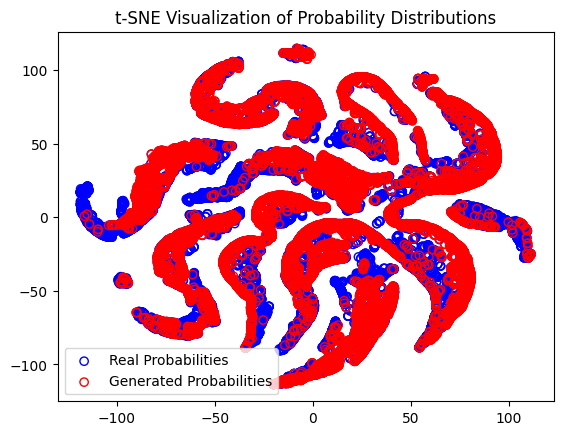

In [20]:
combined_probabilities = np.concatenate((class_probs, generated_probs), axis=0)
# 使用t-SNE进行降维
tsne = TSNE(n_components=2, random_state=42)
embeddings = tsne.fit_transform(combined_probabilities)

# 绘制降维后的数据点
plt.scatter(embeddings[:len(class_probs), 0], embeddings[:len(class_probs), 1], marker='o', facecolors='none', edgecolors='blue', label='Real Probabilities')
plt.scatter(embeddings[len(generated_probs):, 0], embeddings[len(generated_probs):, 1], marker='o', facecolors='none', edgecolors='red', label='Generated Probabilities')
plt.legend()
plt.title('t-SNE Visualization of Probability Distributions')
plt.show()